라이브러리 불러오기

In [42]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import glob
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


warnings.filterwarnings('ignore') # 경고 메시지 뜨지 않게

이미지 불러오기 및 전처리

In [43]:
# 데이터셋 읽어오기

# 훈련셋 불러오기
image_data = os.path.expanduser('~/aiffel/jellyfish/Train_Test_Valid/Train')
pd.DataFrame(os.listdir(image_data), columns=['Files_Name'])

,Files_Name
0,Moon_jellyfish
1,lions_mane_jellyfish
2,.ipynb_checkpoints
3,blue_jellyfish
4,mauve_stinger_jellyfish
5,barrel_jellyfish
6,compass_jellyfish


In [44]:
# 검증셋 불러오기
image_valid_data = os.path.expanduser('~/aiffel/jellyfish/Train_Test_Valid/valid')
pd.DataFrame(os.listdir(image_valid_data), columns=['Files_Name'])

,Files_Name
0,Moon_jellyfish
1,lions_mane_jellyfish
2,blue_jellyfish
3,mauve_stinger_jellyfish
4,barrel_jellyfish
5,compass_jellyfish


In [45]:
# 데이터프레임을 생성하는 함수 정의
def create_dataframe(image_folder):
    files = glob.glob(os.path.join(image_folder, '**', '*.*'), recursive=True)  # 모든 파일을 재귀적으로 검색
    np.random.shuffle(files)  # 파일을 섞음
    labels = [os.path.basename(os.path.dirname(f)) for f in files]  # 폴더 이름에서 라벨 추출
    return pd.DataFrame({'Image': files, 'Label': labels})

# 훈련 및 검증 데이터프레임 생성
dataframe_train = create_dataframe(image_data)
dataframe_valid = create_dataframe(image_valid_data)

# 데이터프레임의 첫 몇 행을 표시
dataframe_train.head(), dataframe_valid.head()

(                                               Image                 Label
 0  /aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...  lions_mane_jellyfish
 1  /aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...      barrel_jellyfish
 2  /aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...      barrel_jellyfish
 3  /aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...        Moon_jellyfish
 4  /aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...        Moon_jellyfish,
                                                Image                    Label
 0  /aiffel/aiffel/jellyfish/Train_Test_Valid/vali...     lions_mane_jellyfish
 1  /aiffel/aiffel/jellyfish/Train_Test_Valid/vali...  mauve_stinger_jellyfish
 2  /aiffel/aiffel/jellyfish/Train_Test_Valid/vali...  mauve_stinger_jellyfish
 3  /aiffel/aiffel/jellyfish/Train_Test_Valid/vali...        compass_jellyfish
 4  /aiffel/aiffel/jellyfish/Train_Test_Valid/vali...     lions_mane_jellyfish)

Dataset                   Training  Validation
Label                                         
Moon_jellyfish           16.666667   15.384615
barrel_jellyfish         16.666667   12.820513
blue_jellyfish           16.666667   17.948718
compass_jellyfish        16.666667   17.948718
lions_mane_jellyfish     16.666667   17.948718
mauve_stinger_jellyfish  16.666667   17.948718


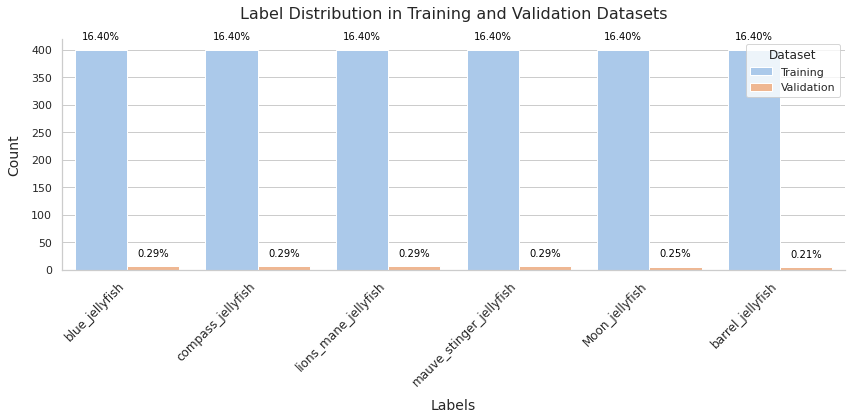

In [46]:
# 훈련 및 검증 데이터프레임에 데이터셋 구분 열 추가
dataframe_train['Dataset'] = 'Training'
dataframe_valid['Dataset'] = 'Validation'

# 두 데이터프레임을 결합
combined_df = pd.concat([dataframe_train, dataframe_valid], ignore_index=True)

# 더 나은 미관을 위해 테마 설정
sns.set_theme(style="whitegrid")

# 각 데이터셋의 라벨별 개수 및 비율 계산
count_data = combined_df.groupby(['Label', 'Dataset']).size().unstack(fill_value=0)
percentage_data = count_data.div(count_data.sum(axis=0), axis=1) * 100

# 비율 데이터 출력 (선택 사항)
print(percentage_data)

# 막대의 색상 팔레트 생성
palette = sns.color_palette("pastel", len(count_data))

# 훈련 및 검증 데이터셋의 라벨 분포를 나타내는 막대 그래프 생성
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=combined_df, x="Label", hue="Dataset", order=count_data.sum(axis=1).sort_values(ascending=False).index, palette="pastel")

# 각 막대에 비율 값 주석 추가
for p in ax.patches:
    height = p.get_height()  # 막대의 높이 가져오기
    percentage = f'{(height / len(combined_df)) * 100:.2f}%'  # 비율 계산
    ax.annotate(percentage,  # 주석으로 추가할 라벨
                (p.get_x() + p.get_width() / 2., height),  # 라벨의 위치
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

# x축 라벨을 더 잘 보이도록 회전하고 폰트 크기 설정
plt.xticks(rotation=45, ha='right', fontsize=12)

# 제목과 라벨 추가 (폰트 및 패딩 개선)
plt.title("Label Distribution in Training and Validation Datasets", fontsize=16, pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

# 상단과 오른쪽 테두리를 제거하여 깔끔한 모양으로 만듦
sns.despine()

# 그래프를 표시
plt.tight_layout()  # 겹침을 방지하기 위해 레이아웃 조정
plt.show()

전체 데이터 개수: 2479
훈련 세트 개수: 1735 (69.99%)
검증 세트 개수: 496 (20.01%)
테스트 세트 개수: 248 (10.00%)


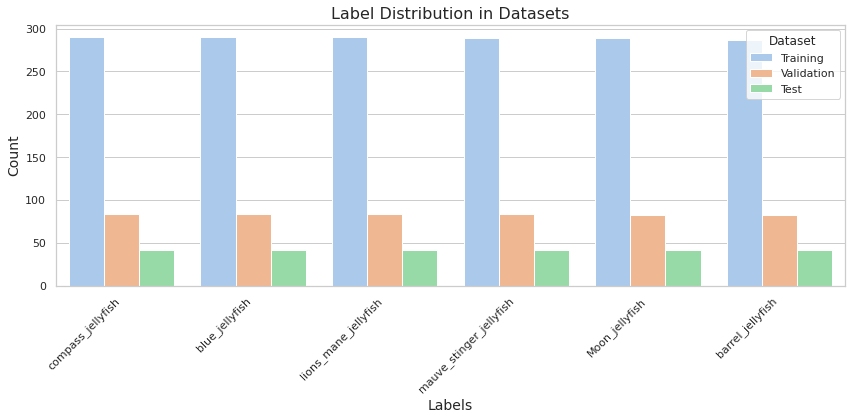

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


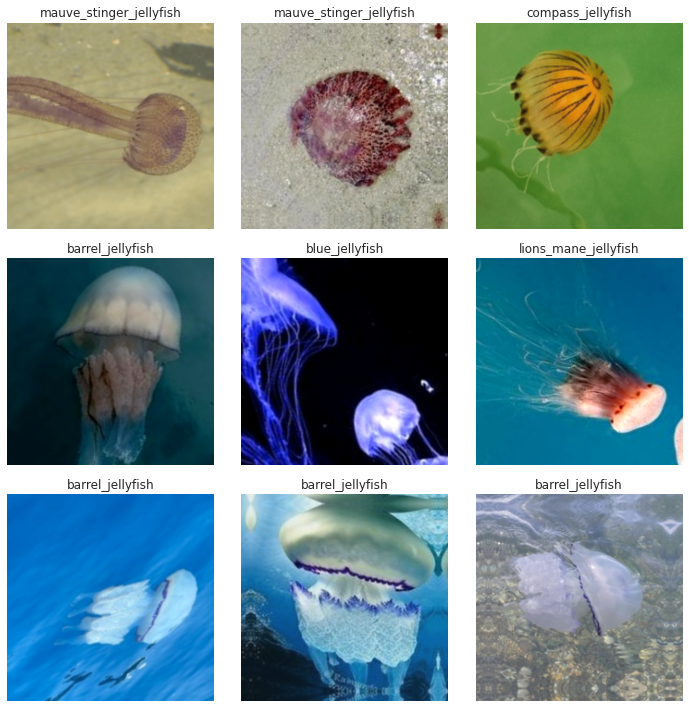

In [47]:
# 데이터 디렉토리 설정
train_dir = os.path.expanduser('~/aiffel/jellyfish/Train_Test_Valid/Train')
valid_dir = os.path.expanduser('~/aiffel/jellyfish/Train_Test_Valid/valid')
test_dir = os.path.expanduser('~/aiffel/jellyfish/Train_Test_Valid/test')

# 모든 데이터를 합치기
def get_file_paths_and_labels(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    file_paths.append(os.path.join(class_dir, fname))
                    labels.append(class_name)
    return file_paths, labels

# 각 폴더에서 이미지와 라벨 불러오기
train_file_paths, train_labels = get_file_paths_and_labels(train_dir)
valid_file_paths, valid_labels = get_file_paths_and_labels(valid_dir)
test_file_paths, test_labels = get_file_paths_and_labels(test_dir)

# 모든 데이터를 합치기
all_file_paths = train_file_paths + valid_file_paths + test_file_paths
all_labels = train_labels + valid_labels + test_labels

# 데이터프레임 생성
data_df = pd.DataFrame({'file_path': all_file_paths, 'label': all_labels})

# 라벨 인코딩
class_names = sorted(data_df['label'].unique())
num_classes = len(class_names)
label_to_index = dict((name, index) for index, name in enumerate(class_names))
data_df['label_index'] = data_df['label'].map(label_to_index)

# 데이터를 원하는 비율로 훈련, 검증, 테스트 세트로 분할
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    data_df['file_path'], data_df['label_index'],
    test_size=0.1,  # 전체 데이터의 10%를 테스트 세트로 사용
    stratify=data_df['label_index'],
    random_state=123
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.2222,  # 남은 데이터의 22.22%를 검증 세트로 사용하여 전체의 20%가 되도록 설정
    stratify=train_val_labels,
    random_state=123
)

# 분할된 데이터의 비율 확인
total_count = len(data_df)
train_count = len(train_paths)
val_count = len(val_paths)
test_count = len(test_paths)

print(f"전체 데이터 개수: {total_count}")
print(f"훈련 세트 개수: {train_count} ({train_count/total_count*100:.2f}%)")
print(f"검증 세트 개수: {val_count} ({val_count/total_count*100:.2f}%)")
print(f"테스트 세트 개수: {test_count} ({test_count/total_count*100:.2f}%)")

# 라벨별 개수 시각화
def plot_label_distribution(labels, dataset_name):
    label_counts = pd.Series(labels).value_counts()
    label_counts.index = [class_names[i] for i in label_counts.index]
    df = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})
    df['Dataset'] = dataset_name
    return df

train_df = plot_label_distribution(train_labels, 'Training')
val_df = plot_label_distribution(val_labels, 'Validation')
test_df = plot_label_distribution(test_labels, 'Test')

combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(data=combined_df, x='Label', y='Count', hue='Dataset', palette='pastel')
plt.xticks(rotation=45, ha='right')
plt.title('Label Distribution in Datasets', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

# 이미지 전처리 함수 정의
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # 정규화
    return image, label

# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# 훈련 데이터셋 생성
train_ds = tf.data.Dataset.from_tensor_slices((list(train_paths), list(train_labels)))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

# 검증 데이터셋 생성
val_ds = tf.data.Dataset.from_tensor_slices((list(val_paths), list(val_labels)))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# 테스트 데이터셋 생성
test_ds = tf.data.Dataset.from_tensor_slices((list(test_paths), list(test_labels)))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# 배치 및 프리페치 설정
batch_size = 16

train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 데이터 증강 결과 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = images[i].numpy()
        label = class_names[labels[i]]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.title(label)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [48]:
# Pre-trained ResNet50 모델을 불러옵니다.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #최상위 분류 레이어를 제외하고, 기본적인 특성 추출 부분만 불러옵니다.
base_model.trainble = False           # 모델층의 동결

In [49]:
# Custom Classification Head 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 경량화된 특성 추출
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout으로 과적합 방지
outputs = Dense(6, activation='softmax')(x)  # 6개 클래스 분류
model = Model(base_model.input, outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

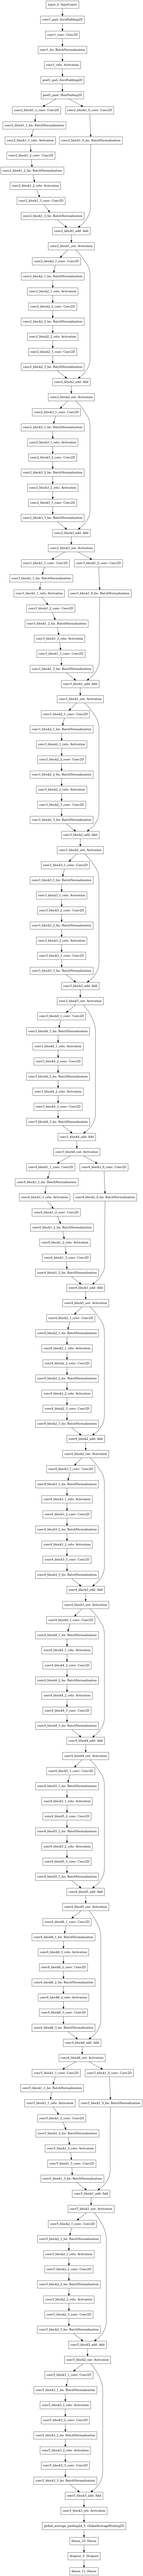

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model)

모델 컴파일

In [51]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),   # Adam 최적화 알고리즘 (일반적으로 잘 동작)
    loss='sparse_categorical_crossentropy',  # 타겟의 출력이 원-핫 인코딩된 형태가 아니라 정수형 라벨로 되어 있음. 다중 클래스 분류를 위한 손실 함수
    metrics=['accuracy']  # 모델의 정확도를 평가 지표로 사용
)

모델 훈련

In [52]:
callbacks = [
#    keras.callbacks.EarlyStopping(
#    monitor='val_loss',  # 검증 손실을 모니터링
#    patience=10,          # 검증 손실이 5번 에폭 동안 개선되지 않으면 훈련 중단
#    verbose=1,           # 중단 메시지 출력
#    restore_best_weights=True),  # 훈련 중단 시 가장 좋은 모델의 가중치를 복원

    keras.callbacks.ModelCheckpoint(
    'ResNet_model.keras',  # 모델 저장 경로
    monitor='val_loss',    # 검증 손실을 기준으로 저장
    save_best_only=True,  # 가장 좋은 모델만 저장
    verbose=1)             # 저장 시 메시지 출력
]

history = model.fit(
    train_ds,  # 훈련 데이터
    epochs=100,
    validation_data=val_ds,  # 검증 데이터
    callbacks=callbacks)

Epoch 1/100
109/109 [==============================] - 31s 198ms/step - loss: 0.6387 - accuracy: 0.7741 - val_loss: 2.1681 - val_accuracy: 0.1714

Epoch 00001: val_loss improved from inf to 2.16813, saving model to ResNet_model.keras
Epoch 2/100
109/109 [==============================] - 26s 193ms/step - loss: 0.3195 - accuracy: 0.8830 - val_loss: 2.6483 - val_accuracy: 0.1673

Epoch 00002: val_loss did not improve from 2.16813
Epoch 3/100
109/109 [==============================] - 25s 190ms/step - loss: 0.2161 - accuracy: 0.9274 - val_loss: 2.0623 - val_accuracy: 0.1452

Epoch 00003: val_loss improved from 2.16813 to 2.06230, saving model to ResNet_model.keras
Epoch 4/100
109/109 [==============================] - 25s 190ms/step - loss: 0.2187 - accuracy: 0.9285 - val_loss: 3.6829 - val_accuracy: 0.2601

Epoch 00004: val_loss did not improve from 2.06230
Epoch 5/100
109/109 [==============================] - 26s 192ms/step - loss: 0.2372 - accuracy: 0.9228 - val_loss: 1.5138 - val_acc

학습결과

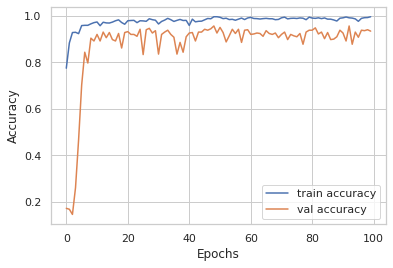

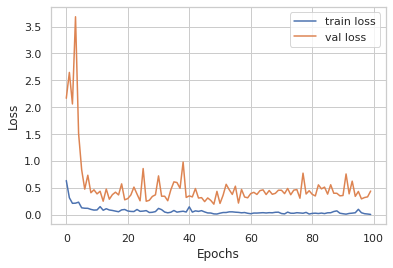

In [53]:
# 훈련 정확도와 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 훈련 손실과 검증 손실 시각화
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)

# 평가 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 - 1s - loss: 0.5502 - accuracy: 0.9315
Test Loss: 0.5501700639724731
Test Accuracy: 0.9314516186714172


In [55]:

model1 = tf.keras.models.load_model('ResNet_model.keras')

test_loss, test_accuracy = model1.evaluate(test_ds, verbose=2)

# 평가 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 - 2s - loss: 0.3437 - accuracy: 0.9395
Test Loss: 0.3437168002128601
Test Accuracy: 0.9395161271095276
